# Análise do Dataset

In [4]:
import pandas as pd

filename = "Salary_Dataset.csv"
df_dirty = pd.read_csv(filename)

df_dirty

,Company Name,Job Title,Salaries Reported,Location,Salary
0,Mu Sigma,Data Scientist,105.0,Bangalore,"₹6,48,573/yr"
1,IBM,Data Scientist,95.0,Bangalore,"₹11,91,950/yr"
2,Tata Consultancy Services,Data Scientist,66.0,Bangalore,"₹8,36,874/yr"
3,Impact Analytics,Data Scientist,40.0,Bangalore,"₹6,69,578/yr"
4,Accenture,Data Scientist,32.0,Bangalore,"₹9,44,110/yr"
...,...,...,...,...,...
4339,TaiyōAI,Machine Learning Scientist,1.0,Mumbai,"₹5,180/mo"
4340,Decimal Point Analytics,Machine Learning Developer,1.0,Mumbai,"₹7,51,286/yr"
4341,MyWays,Machine Learning Developer,1.0,Mumbai,"₹4,10,952/yr"
4342,Market Pulse Technologies,Software Engineer - Machine Learning,1.0,Mumbai,"₹16,12,324/yr"


In [5]:
df_dirty.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4344 entries, 0 to 4343
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Company Name       4341 non-null   object 
 1   Job Title          4344 non-null   object 
 2   Salaries Reported  4342 non-null   float64
 3   Location           4344 non-null   object 
 4   Salary             4344 non-null   object 
dtypes: float64(1), object(4)
memory usage: 169.8+ KB


In [6]:
df_dirty.isnull().sum()

Company Name         3
Job Title            0
Salaries Reported    2
Location             0
Salary               0
dtype: int64

In [7]:
df_dirty[df_dirty["Salaries Reported"].isnull()]

,Company Name,Job Title,Salaries Reported,Location,Salary
4027,First Student Data Scientist,Data Analyst,NaN,Pune,"₹4,53,300/yr"
4237,Amazon,Machine Learning Data Associate II,NaN,New Delhi,"₹3,29,439/yr"


In [8]:
df_dirty[df_dirty["Company Name"].isnull()]

,Company Name,Job Title,Salaries Reported,Location,Salary
2279,NaN,Data Analyst,1.0,Pune,"₹23,500/mo"
3227,NaN,Data Engineer,1.0,Pune,"₹26,20,604/yr"
4026,NaN,Machine Learning Engineer/Data Scientist,1.0,Pune,"₹56,465/mo"


# Tratamento de dados

## Remoção de dados nulos

In [26]:
df = df_dirty.dropna(axis='rows')
df = df[df["Salaries Reported"].notnull()].copy()
df = df[df["Company Name"].notnull()].copy()

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4339 entries, 0 to 4343
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Company Name       4339 non-null   object 
 1   Job Title          4339 non-null   object 
 2   Salaries Reported  4339 non-null   float64
 3   Location           4339 non-null   object 
 4   Salary             4339 non-null   object 
dtypes: float64(1), object(4)
memory usage: 203.4+ KB


In [27]:
df.isnull().sum()

Company Name         0
Job Title            0
Salaries Reported    0
Location             0
Salary               0
dtype: int64

## Conversão das Moedas para Rúpias indianas e Remoção das Moedas Fora do Padrão

In [21]:
import re
import pandas as pd

# Taxa de câmbio apenas para INR (₹) → USD
TAXA_INR_USD = 83.0  # 1 USD = 83 INR

# Moedas que devem ser REMOVIDAS (não convertidas)
MOEDAS_REMOVER = {'$', '£', 'AFN'}

# Função para verificar se a linha deve ser removida
def deve_remover(salario_str):
    if pd.isnull(salario_str):
        return False
    return any(moeda in salario_str for moeda in MOEDAS_REMOVER)

# Filtrar o DataFrame (remover linhas com $, £, AFN)
df = df[~df["Salary"].apply(deve_remover)].copy()

# Função para converter apenas INR (₹) para USD/hora
def converter_inr_para_usd_hr(salario_str):
    if pd.isnull(salario_str) or '₹' not in salario_str:
        return None  # Ignora se não for INR

    # Remove ₹ e vírgulas, extrai valor e unidade
    salario_limpo = salario_str.replace('₹', '').replace(',', '').strip()
    match = re.match(r"(\d+)(?:/(\w+))?", salario_limpo)
    if not match:
        return None

    valor = float(match.group(1))
    unidade = match.group(2)

    # Converte para USD/hora
    if unidade == 'mo':  # Se for mensal → converter para hora
        valor_hr = (valor / TAXA_INR_USD) / (160)  # 160 horas/mês (assumindo 40h/semana)
    elif unidade == 'yr':  # Se for anual → converter para hora
        valor_hr = (valor / TAXA_INR_USD) / 2080  # 2080 horas/ano
    elif unidade == 'hr' or not unidade:  # Se já for por hora ou sem unidade (assume hr)
        valor_hr = valor / TAXA_INR_USD
    else:
        return None  # Unidade desconhecida

    return round(valor_hr, 2)  # Arredonda para 2 casas decimais

# Aplicar a conversão
df["Salary_usd"] = df["Salary"].apply(converter_inr_para_usd_hr)

# Remover linhas onde a conversão falhou (NaN)
df = df.dropna(subset=["Salary_usd"])

# Resultado
print(f"Linhas originais: {len(df)} | Linhas após filtro: {len(df)}")
df.head()

Linhas originais: 4313 | Linhas após filtro: 4313


,Company Name,Job Title,Salaries Reported,Location,Salary,Salary_usd
0,Mu Sigma,Data Scientist,105.0,Bangalore,"₹6,48,573/yr",3.76
1,IBM,Data Scientist,95.0,Bangalore,"₹11,91,950/yr",6.90
2,Tata Consultancy Services,Data Scientist,66.0,Bangalore,"₹8,36,874/yr",4.85
3,Impact Analytics,Data Scientist,40.0,Bangalore,"₹6,69,578/yr",3.88
4,Accenture,Data Scientist,32.0,Bangalore,"₹9,44,110/yr",5.47


# Análise dos dados após o tratamento

## Análise Exploratória

<ipython-input-10-d9972c846d26>:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
<ipython-input-10-d9972c846d26>:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
<ipython-input-10-d9972c846d26>:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
<ipython-input-10-d9972c846d26>:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


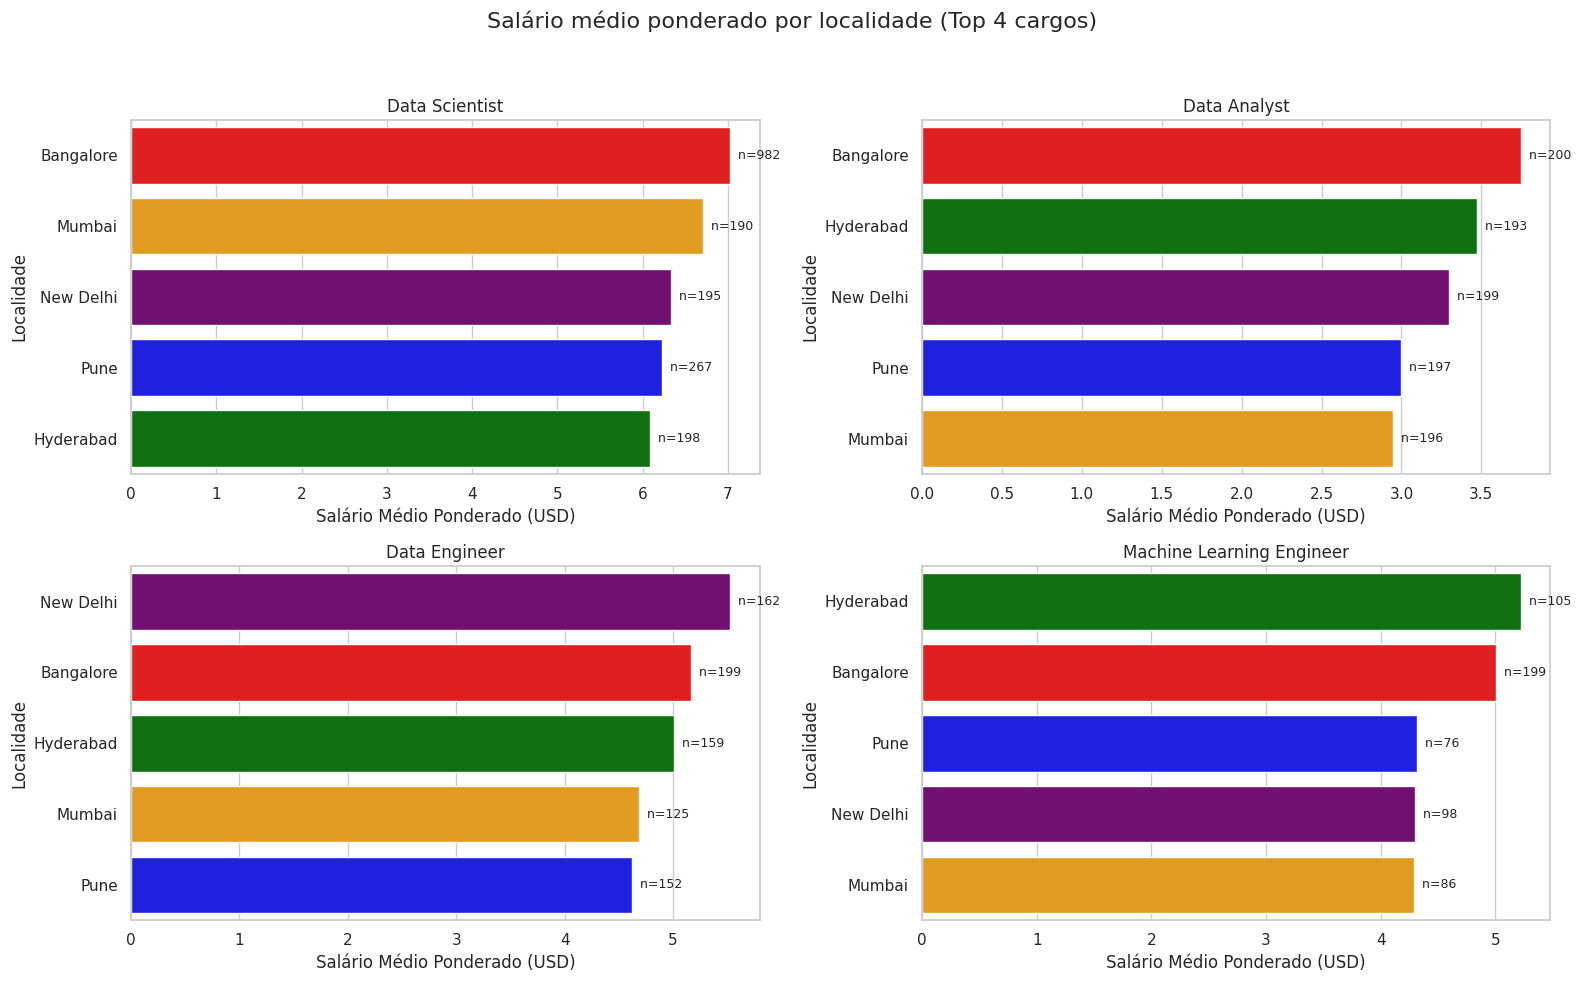

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Estilo dos gráficos
sns.set(style="whitegrid")

# Selecionar os 4 job titles mais frequentes
top_job_titles = df["Job Title"].value_counts().nlargest(4).index.tolist()

# Gerar cores fixas para localizações
todas_cidades = df["Location"].unique()
cores_fixas = ['red', 'blue', 'green', 'purple', 'orange', 'cyan', 'gray']
mapa_cores = {cidade: cores_fixas[i % len(cores_fixas)] for i, cidade in enumerate(todas_cidades)}

# Criar subplots
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
fig.suptitle("Salário médio ponderado por localidade (Top 4 cargos)", fontsize=16)

for i, job in enumerate(top_job_titles):
    df_job = df[(df["Job Title"] == job) & (df["Salary_usd"] < 250000)].copy()  # ← FILTRO AQUI

    # Calcular salário ponderado e total de pesos por localidade
    df_job["Salario_Ponderado"] = df_job["Salary_usd"] * df_job["Salaries Reported"]
    agrupado = df_job.groupby("Location").agg(
        salario_total=('Salario_Ponderado', 'sum'),
        peso_total=('Salaries Reported', 'sum'),
        amostras=('Salary_usd', 'count')
    )
    agrupado["Media_Ponderada"] = agrupado["salario_total"] / agrupado["peso_total"]

    # Ordenar por média
    agrupado = agrupado.sort_values("Media_Ponderada", ascending=False)

    # Cores consistentes por cidade
    cores = [mapa_cores[cidade] for cidade in agrupado.index]

    # Subplot correto
    ax = axes[i // 2, i % 2]

    # Plotar gráfico
    sns.barplot(
        x=agrupado["Media_Ponderada"],
        y=agrupado.index,
        palette=cores,
        ax=ax
    )
    ax.set_title(job)
    ax.set_xlabel("Salário Médio Ponderado (USD)")
    ax.set_ylabel("Localidade")

    # Adicionar número de amostras em cada barra
    for j, (media, n) in enumerate(zip(agrupado["Media_Ponderada"], agrupado["amostras"])):
        ax.text(media, j, f"  n={n}", va='center', ha='left', fontsize=9)

# Ajustar layout
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


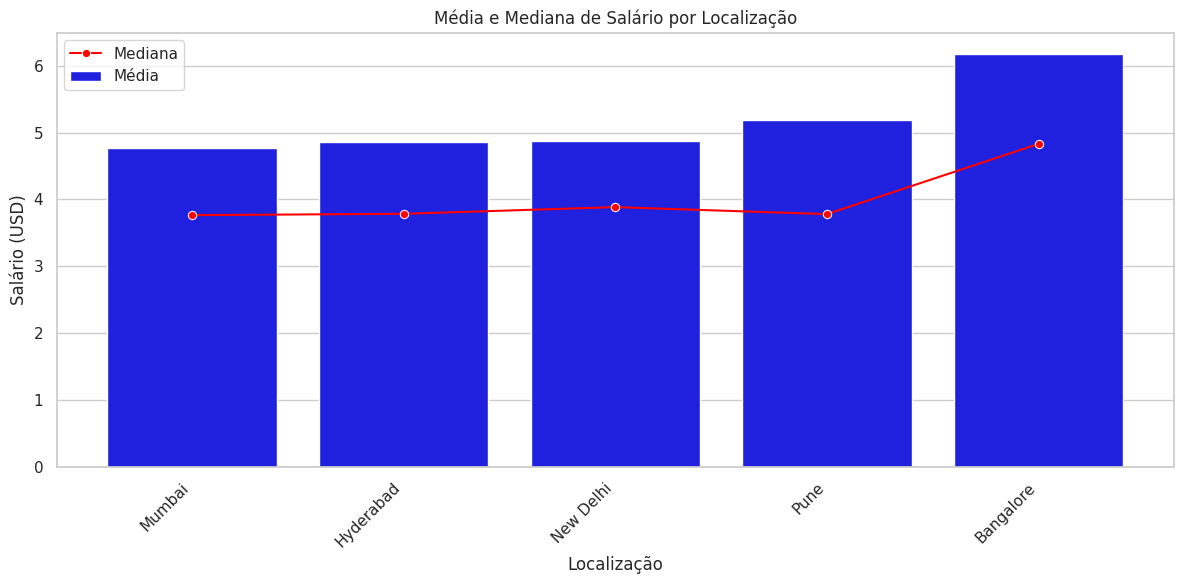

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Pegar os 10 maiores salários médios mas ordenar em ordem crescente para o plot
salaries_by_company = df.groupby("Location")["Salary_usd"].mean()
top_locations = salaries_by_company.nlargest(10).sort_values(ascending=True).index
medians_by_company = df.groupby("Location")["Salary_usd"].median()

# Criar o plot
plt.figure(figsize=(12, 6))
ax = sns.barplot(x=top_locations, y=salaries_by_company[top_locations], color='blue', label='Média')

# Adicionar linha para medianas
sns.lineplot(x=np.arange(len(top_locations)),
             y=medians_by_company[top_locations],
             color='red', marker='o', ax=ax, label='Mediana')

# Customizar o plot
plt.xticks(rotation=45, ha="right")
plt.xlabel("Localização")
plt.ylabel("Salário (USD)")
plt.title("Média e Mediana de Salário por Localização")
plt.legend()

# Ajustar layout
plt.tight_layout()
plt.show()

<ipython-input-614-63be71b3796c>:23: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

<ipython-input-614-63be71b3796c>:23: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

<ipython-input-614-63be71b3796c>:23: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

<ipython-input-614-63be71b3796c>:23: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False

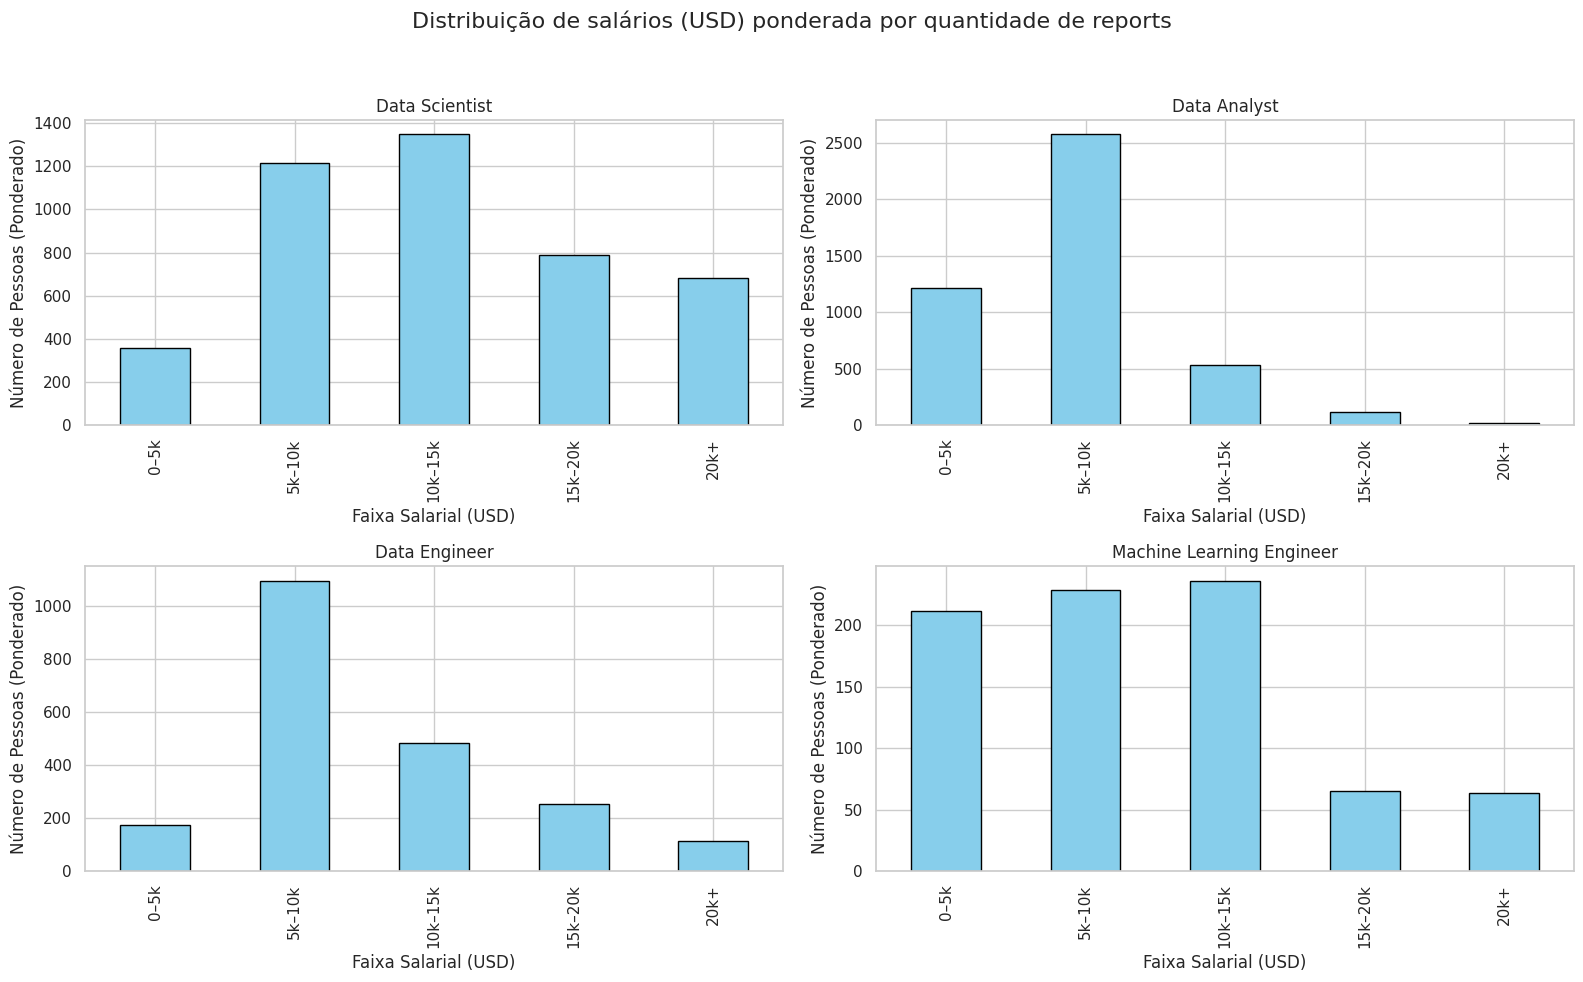

In [ ]:
# Estilo
sns.set(style="whitegrid")

# Selecionar os 4 job titles mais frequentes
top_job_titles = df["Job Title"].value_counts().nlargest(4).index.tolist()

# Definir os bins manuais (em USD)
bins = [0, 5000/2080, 10000/2080, 15000/2080, 20000/2080, float('inf')]
bin_labels = ["0–5k", "5k–10k", "10k–15k", "15k–20k", "20k+"]

# Criar subplots
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
fig.suptitle("Distribuição de salários (USD) ponderada por quantidade de reports", fontsize=16)

# Loop para cada job title
for i, job in enumerate(top_job_titles):
    df_job = df[df["Job Title"] == job].copy()

    # Classifica cada salário em uma faixa
    df_job["Faixa"] = pd.cut(df_job["Salary_usd"], bins=bins, labels=bin_labels, right=False)

    # Agrupa por faixa e soma os salários reportados como peso
    faixa_counts = df_job.groupby("Faixa")["Salaries Reported"].sum().reindex(bin_labels, fill_value=0)

    # Subplot correspondente
    ax = axes[i // 2, i % 2]
    faixa_counts.plot(kind="bar", ax=ax, color="skyblue", edgecolor="black")

    ax.set_title(job)
    ax.set_xlabel("Faixa Salarial (USD)")
    ax.set_ylabel("Número de Pessoas (Ponderado)")
    ax.grid(True, axis='y')

# Ajustar layout
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


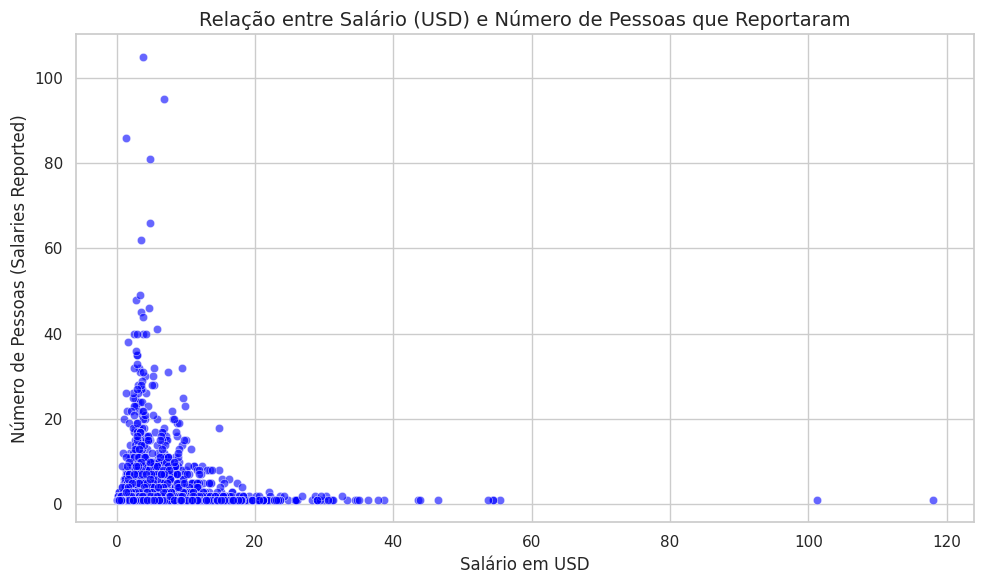

In [ ]:
# Estilo do gráfico
sns.set(style="whitegrid")

# Criar scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x="Salary_usd", y="Salaries Reported", color="blue", alpha=0.6)

# Títulos e rótulos
plt.title("Relação entre Salário (USD) e Número de Pessoas que Reportaram", fontsize=14)
plt.xlabel("Salário em USD")
plt.ylabel("Número de Pessoas (Salaries Reported)")

plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
print("12 Menores Salarios do Dataset")
df.sort_values(by="Salary_usd", ascending=True).head(12)

12 Menores Salarios do Dataset


,Company Name,Job Title,Salaries Reported,Location,Salary,Salary_usd
2471,Orbit Technologies,Data Analyst,1.0,Hyderabad,"₹10,814/yr",0.06
3873,20K Group,Machine Learning Engineer,1.0,Bangalore,"₹21,628/yr",0.13
2288,Fran Biz,Data Analyst,1.0,Pune,"₹2,010/mo",0.15
2490,Wipro Technologies,Data Analyst,1.0,Hyderabad,"₹2,063/mo",0.16
2248,Friends Union for Energising Lives (Fuel),Data Analyst,2.0,Pune,"₹2,460/mo",0.19
2740,Blackcoffer,Data Analyst,2.0,New Delhi,"₹3,084/mo",0.23
2814,iAastha,Data Analyst,2.0,Mumbai,"₹3,278/mo",0.25
2921,20K Group,Data Analyst,1.0,Mumbai,"₹42,892/yr",0.25
4333,Knowledge Solutions India,Machine Learning Engineer,1.0,Mumbai,"₹3,762/mo",0.28
791,pion.ai,Data Scientist,1.0,Bangalore,"₹50,613/yr",0.29


In [ ]:
# Filtrar apenas linhas com moedas diferentes de ₹ (ou seja, moeda ≠ '₹')
linhas_nao_inr = df[df["Salary"].apply(lambda x: '₹' not in str(x))]

print("Os Salarios em moedas diferentes de ₹")
# Exibir resultado
linhas_nao_inr[["Company Name", "Job Title","Location","Salaries Reported", "Salary", "Salary_usd"]].sort_values(by="Salary_usd", ascending=False)

Os Salarios em moedas diferentes de ₹


,Company Name,Job Title,Location,Salaries Reported,Salary,Salary_usd


## Preparação dos Dados Para os Primeiros Testes de Regressão

In [ ]:
# Remover a coluna Salary
df = df.drop(columns=["Salary"])

df_ohe = pd.get_dummies(df, columns=['Job Title', 'Location'])
df_ohe

,Company Name,Salaries Reported,Salary_usd,Job Title_Associate Machine Learning Engineer,Job Title_Data Analyst,Job Title_Data Engineer,Job Title_Data Science,Job Title_Data Science Associate,Job Title_Data Science Consultant,Job Title_Data Science Lead,...,Job Title_Machine Learning Scientist,Job Title_Machine Learning Software Engineer,Job Title_Senior Data Scientist,Job Title_Senior Machine Learning Engineer,Job Title_Software Engineer - Machine Learning,Location_Bangalore,Location_Hyderabad,Location_Mumbai,Location_New Delhi,Location_Pune
0,Mu Sigma,105.0,3.76,False,False,False,False,False,False,False,...,False,False,False,False,False,True,False,False,False,False
1,IBM,95.0,6.90,False,False,False,False,False,False,False,...,False,False,False,False,False,True,False,False,False,False
2,Tata Consultancy Services,66.0,4.85,False,False,False,False,False,False,False,...,False,False,False,False,False,True,False,False,False,False
3,Impact Analytics,40.0,3.88,False,False,False,False,False,False,False,...,False,False,False,False,False,True,False,False,False,False
4,Accenture,32.0,5.47,False,False,False,False,False,False,False,...,False,False,False,False,False,True,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4339,TaiyōAI,1.0,0.39,False,False,False,False,False,False,False,...,True,False,False,False,False,False,False,True,False,False
4340,Decimal Point Analytics,1.0,4.35,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
4341,MyWays,1.0,2.38,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
4342,Market Pulse Technologies,1.0,9.34,False,False,False,False,False,False,False,...,False,False,False,False,True,False,False,True,False,False


### DecisionTreeRegressor

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
import plotly.express as px
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
from plotly.subplots import make_subplots
import plotly.graph_objects as go

# Divide os dados de teste
y = df_ohe["Salary_usd"]
X = df_ohe.drop(columns=["Salary_usd"]+['Company Name'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

regressor = DecisionTreeRegressor(max_depth=5)
regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)

# Cálculo das métricas para Decision Tree
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

df_predicted = pd.DataFrame({'Salario Real': y_test, 'Salario Predito': y_pred})

# Ordenar os dados pelo índice antes de plotar
df_predicted_sorted = df_predicted.sort_index()

# Criar figura com subplots
fig = make_subplots(
    rows=1,
    cols=1,
    subplot_titles=("DecisionTreeRegressor"),
    vertical_spacing=0.2
)

# Gráfico 1 (Decision Tree)
fig.add_trace(go.Scatter(
    x=df_predicted_sorted.index,
    y=df_predicted_sorted['Salario Real'],
    name='Real',
    mode='markers',
    marker=dict(color='blue', size=6)
), row=1, col=1)

fig.add_trace(go.Scatter(
    x=df_predicted_sorted.index,
    y=df_predicted_sorted['Salario Predito'],
    name='Predito (DT)',
    mode='lines',
    line=dict(color='red', width=2)
), row=1, col=1)

# Função para adicionar métricas no canto superior direito
def add_metrics(fig, rmse, r2, row):
    fig.add_annotation(
        text=f'<b>RMSE:</b> {rmse:.2f}<br><b>R²:</b> {r2*100:.2f}%',
        showarrow=False,
        align='right',
        bgcolor='rgba(255, 255, 255, 0.8)',
        bordercolor='black',
        borderwidth=1,
        font=dict(size=12),
        row=row,
        col=1
    )

# Adicionar métricas para ambos os modelos
add_metrics(fig, rmse, r2, 1)  # Decision Tree

# Ajustar layout
fig.update_layout(
    height=400,
    width=900,
    title_text="Decision Tree: Salário Real vs Predito",
    title_x=0.5,
    showlegend=True,
    legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="right", x=1),
    margin=dict(t=100, b=80)
)

# Configurar eixos Y e X
fig.update_yaxes(title_text="Salário (USD)", row=1, col=1)
fig.update_xaxes(title_text="Amostras", row=1, col=1)

fig.show()

### RandomForestRegressor

In [ ]:
from sklearn.ensemble import RandomForestRegressor

# Configura os parametros do RandomForestRegressor
rf = RandomForestRegressor(n_estimators=1024, max_features='sqrt', max_depth=5, random_state=18)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

# Cálculo das métricas para RandomForestRegressor
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

df_predicted = pd.DataFrame({'Salario Real': y_test, 'Salario Predito': y_pred})

# Ordenar os dados pelo índice antes de plotar
df_predicted_sorted = df_predicted.sort_index()

# Criar figura com subplots
fig = make_subplots(
    rows=1,
    cols=1,
    subplot_titles=("RandomForestRegressor"),
    vertical_spacing=0.2
)

fig.add_trace(go.Scatter(
    x=df_predicted_sorted.index,
    y=df_predicted_sorted['Salario Real'],
    name='Real',
    mode='markers',
    marker=dict(color='blue', size=6)
), row=1, col=1)

fig.add_trace(go.Scatter(
    x=df_predicted_sorted.index,
    y=df_predicted_sorted['Salario Predito'],
    name='Predito (DT)',
    mode='lines',
    line=dict(color='red', width=2)
), row=1, col=1)

# Adicionar métricas para o modelo
add_metrics(fig, rmse, r2, 1)

# Ajustar layout
fig.update_layout(
    height=400,
    width=900,
    title_text="Random Forest: Salário Real vs Predito",
    title_x=0.5,
    showlegend=True,
    legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="right", x=1),
    margin=dict(t=100, b=80)
)

# Configurar eixos Y e X
fig.update_yaxes(title_text="Salário (USD)", row=1, col=1)
fig.update_xaxes(title_text="Amostras", row=1, col=1)

fig.show()

## Filtragem de Dados

### Remoção da variação de salario de um mesmo emprego em uma mesma empresa

In [ ]:
# Passo 1: Agrupar por Job Title, Location e Company, e manter apenas a linha com o maior Salaries Reported
df_filtered = df.sort_values('Salaries Reported', ascending=False) \
                              .groupby(['Job Title', 'Location', 'Company Name']) \
                              .first() \
                              .reset_index()

# Passo 2: Verificar o resultado
print(f"Linhas originais: {len(df)}")
print(f"Linhas após filtro: {len(df_filtered)}")

Linhas originais: 4313
Linhas após filtro: 4002


In [ ]:
# Preapara o dataset para a regressao
df_filtered_ohe = pd.get_dummies(df_filtered, columns=['Job Title', 'Location'])

y = df_filtered_ohe["Salary_usd"]
X = df_filtered_ohe.drop(columns=["Salary_usd"]+['Company Name'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

# Primeiro modelo (Decision Tree)
regressor.fit(X_train, y_train)
y_pred_dt = regressor.predict(X_test)

# Cálculo das métricas para Decision Tree
rmse_dt = np.sqrt(mean_squared_error(y_test, y_pred_dt))
r2_dt = r2_score(y_test, y_pred_dt)

# Dados preditos Decision Tree
df_predicted_dt = pd.DataFrame({'Salario Real': y_test, 'Salario Predito': y_pred_dt})

# Segundo modelo (Random Forest)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

# Cálculo das métricas para Random Forest
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
r2_rf = r2_score(y_test, y_pred_rf)

# Dados preditos Random Forest
df_predicted_rf = pd.DataFrame({'Salario Real': y_test, 'Salario Predito': y_pred_rf})

# Ordenar os dados pelo índice antes de plotar
df_predicted_dt_sorted = df_predicted_dt.sort_index()
df_predicted_rf_sorted = df_predicted_rf.sort_index()

# Criar figura com subplots
fig = make_subplots(
    rows=2,
    cols=1,
    subplot_titles=("DecisionTreeRegressor", "RandomForestRegressor"),
    vertical_spacing=0.2
)

# Gráfico 1 (Decision Tree)
fig.add_trace(go.Scatter(
    x=df_predicted_dt_sorted.index,
    y=df_predicted_dt_sorted['Salario Real'],
    name='Real',
    mode='markers',
    marker=dict(color='blue', size=6)
), row=1, col=1)

fig.add_trace(go.Scatter(
    x=df_predicted_dt_sorted.index,
    y=df_predicted_dt_sorted['Salario Predito'],
    name='Predito (DT)',
    mode='lines',
    line=dict(color='red', width=2)
), row=1, col=1)

# Gráfico 2 (Random Forest)
fig.add_trace(go.Scatter(
    x=df_predicted_rf_sorted.index,
    y=df_predicted_rf_sorted['Salario Real'],
    name='Real',
    mode='markers',
    marker=dict(color='black', size=6),
    showlegend=False
), row=2, col=1)

fig.add_trace(go.Scatter(
    x=df_predicted_rf_sorted.index,
    y=y_pred_rf,  # Garantir que y_pred_rf está na mesma ordem
    name='Predito (RF)',
    mode='lines',
    line=dict(color='green', width=2)
), row=2, col=1)

# Adicionar métricas para ambos os modelos
add_metrics(fig, rmse_dt, r2_dt, 1)  # Decision Tree
add_metrics(fig, rmse_rf, r2_rf, 2)  # Random Forest

# Ajustar layout
fig.update_layout(
    height=800,
    width=900,
    title_text="Comparação de Modelos: Salário Real vs Predito",
    title_x=0.5,
    showlegend=True,
    legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="right", x=1),
    margin=dict(t=100, b=80)
)

# Configurar eixos Y e X
fig.update_yaxes(title_text="Salário (USD)", row=1, col=1)
fig.update_yaxes(title_text="Salário (USD)", row=2, col=1)
fig.update_xaxes(title_text="Amostras", row=2, col=1)

fig.show()

### Exclusão das incidências com baixa quantidade de salarios reportados

In [ ]:
# Passo 1: Filtrar por Bangalore, pegar maior "Salaries Reported" por grupo, e remover <= 3
df_filtered_2 = df_filtered[df_filtered['Salaries Reported'] > 3].reset_index()

# Passo 2: Verificar resultado
print(f"Linhas originais: {len(df_filtered)}")
print(f"Linhas após filtro: {len(df_filtered_2)}")

Linhas originais: 4002
Linhas após filtro: 709


In [ ]:
# Preapara o dataset para a regressao
df_filtered_2_ohe = pd.get_dummies(df_filtered_2, columns=['Job Title', 'Location'])

y = df_filtered_2_ohe["Salary_usd"]
X = df_filtered_2_ohe.drop(columns=["Salary_usd"]+['Company Name'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

# Primeiro modelo (Decision Tree)
regressor.fit(X_train, y_train)
y_pred_dt = regressor.predict(X_test)

# Cálculo das métricas para Decision Tree
rmse_dt = np.sqrt(mean_squared_error(y_test, y_pred_dt))
r2_dt = r2_score(y_test, y_pred_dt)

# Dados preditos Decision Tree
df_predicted_dt = pd.DataFrame({'Salario Real': y_test, 'Salario Predito': y_pred_dt})

# Segundo modelo (Random Forest)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

# Cálculo das métricas para Random Forest
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
r2_rf = r2_score(y_test, y_pred_rf)

# Dados preditos Random Forest
df_predicted_rf = pd.DataFrame({'Salario Real': y_test, 'Salario Predito': y_pred_rf})

# Ordenar os dados pelo índice antes de plotar
df_predicted_dt_sorted = df_predicted_dt.sort_index()
df_predicted_rf_sorted = df_predicted_rf.sort_index()

# Criar figura com subplots
fig = make_subplots(
    rows=2,
    cols=1,
    subplot_titles=("DecisionTreeRegressor", "RandomForestRegressor"),
    vertical_spacing=0.2
)

# Gráfico 1 (Decision Tree)
fig.add_trace(go.Scatter(
    x=df_predicted_dt_sorted.index,
    y=df_predicted_dt_sorted['Salario Real'],
    name='Real',
    mode='markers',
    marker=dict(color='blue', size=6)
), row=1, col=1)

fig.add_trace(go.Scatter(
    x=df_predicted_dt_sorted.index,
    y=df_predicted_dt_sorted['Salario Predito'],
    name='Predito (DT)',
    mode='lines',
    line=dict(color='red', width=2)
), row=1, col=1)

# Gráfico 2 (Random Forest)
fig.add_trace(go.Scatter(
    x=df_predicted_rf_sorted.index,
    y=df_predicted_rf_sorted['Salario Real'],
    name='Real',
    mode='markers',
    marker=dict(color='black', size=6),
    showlegend=False
), row=2, col=1)

fig.add_trace(go.Scatter(
    x=df_predicted_rf_sorted.index,
    y=y_pred_rf,  # Garantir que y_pred_rf está na mesma ordem
    name='Predito (RF)',
    mode='lines',
    line=dict(color='green', width=2)
), row=2, col=1)

# Adicionar métricas para ambos os modelos
add_metrics(fig, rmse_dt, r2_dt, 1)  # Decision Tree
add_metrics(fig, rmse_rf, r2_rf, 2)  # Random Forest

# Ajustar layout
fig.update_layout(
    height=800,
    width=900,
    title_text="Comparação de Modelos: Salário Real vs Predito",
    title_x=0.5,
    showlegend=True,
    legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="right", x=1),
    margin=dict(t=100, b=80)
)

# Configurar eixos Y e X
fig.update_yaxes(title_text="Salário (USD)", row=1, col=1)
fig.update_yaxes(title_text="Salário (USD)", row=2, col=1)
fig.update_xaxes(title_text="Amostras", row=2, col=1)

fig.show()

### Análise das 100 empresas com maior número de salaries reported

In [ ]:
# Passo 1: Identificar as top 100 empresas (somando Salaries Reported)
top_100_companies = (
    df_filtered_2.groupby('Company Name')['Salaries Reported']
    .sum()
    .sort_values(ascending=False)
    .head(100)
    .index  # Pega apenas os nomes das empresas
)

# Passo 2: Filtrar o dataset original para manter linhas dessas empresas E RESETAR O ÍNDICE
df_filtered_3 = (
    df_filtered_2[df_filtered_2['Company Name'].isin(top_100_companies)]
    .copy()
    .reset_index(drop=True)  # Remove o índice antigo e cria um novo (0, 1, 2...)
)

# Verificação
print(f"Linhas originais: {len(df_filtered_2)}")
print(f"Linhas após filtro: {len(df_filtered_3)}")

Linhas originais: 709
Linhas após filtro: 361


In [ ]:
# Preapara o dataset para a regressao
df_filtered_3_ohe = pd.get_dummies(df_filtered_3, columns=['Job Title', 'Location'])

y = df_filtered_3_ohe["Salary_usd"]
X = df_filtered_3_ohe.drop(columns=["Salary_usd"]+['Company Name'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

# Primeiro modelo (Decision Tree)
regressor.fit(X_train, y_train)
y_pred_dt = regressor.predict(X_test)

# Cálculo das métricas para Decision Tree
rmse_dt = np.sqrt(mean_squared_error(y_test, y_pred_dt))
r2_dt = r2_score(y_test, y_pred_dt)

# Dados preditos Decision Tree
df_predicted_dt = pd.DataFrame({'Salario Real': y_test, 'Salario Predito': y_pred_dt})

# Segundo modelo (Random Forest)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

# Cálculo das métricas para Random Forest
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
r2_rf = r2_score(y_test, y_pred_rf)

# Dados preditos Random Forest
df_predicted_rf = pd.DataFrame({'Salario Real': y_test, 'Salario Predito': y_pred_rf})

# Ordenar os dados pelo índice antes de plotar
df_predicted_dt_sorted = df_predicted_dt.sort_index()
df_predicted_rf_sorted = df_predicted_rf.sort_index()

# Criar figura com subplots
fig = make_subplots(
    rows=2,
    cols=1,
    subplot_titles=("DecisionTreeRegressor", "RandomForestRegressor"),
    vertical_spacing=0.2
)

# Gráfico 1 (Decision Tree)
fig.add_trace(go.Scatter(
    x=df_predicted_dt_sorted.index,
    y=df_predicted_dt_sorted['Salario Real'],
    name='Real',
    mode='markers',
    marker=dict(color='blue', size=6)
), row=1, col=1)

fig.add_trace(go.Scatter(
    x=df_predicted_dt_sorted.index,
    y=df_predicted_dt_sorted['Salario Predito'],
    name='Predito (DT)',
    mode='lines',
    line=dict(color='red', width=2)
), row=1, col=1)

# Gráfico 2 (Random Forest)
fig.add_trace(go.Scatter(
    x=df_predicted_rf_sorted.index,
    y=df_predicted_rf_sorted['Salario Real'],
    name='Real',
    mode='markers',
    marker=dict(color='black', size=6),
    showlegend=False
), row=2, col=1)

fig.add_trace(go.Scatter(
    x=df_predicted_rf_sorted.index,
    y=y_pred_rf,  # Garantir que y_pred_rf está na mesma ordem
    name='Predito (RF)',
    mode='lines',
    line=dict(color='green', width=2)
), row=2, col=1)

# Adicionar métricas para ambos os modelos
add_metrics(fig, rmse_dt, r2_dt, 1)  # Decision Tree
add_metrics(fig, rmse_rf, r2_rf, 2)  # Random Forest

# Ajustar layout
fig.update_layout(
    height=800,
    width=900,
    title_text="Comparação de Modelos: Salário Real vs Predito",
    title_x=0.5,
    showlegend=True,
    legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="right", x=1),
    margin=dict(t=100, b=80)
)

# Configurar eixos Y e X
fig.update_yaxes(title_text="Salário (USD)", row=1, col=1)
fig.update_yaxes(title_text="Salário (USD)", row=2, col=1)
fig.update_xaxes(title_text="Amostras", row=2, col=1)

fig.show()